# Data Visualisation Assignment
Using a data set on earthquakes taken from USGS (U.S Geological Survey).

by *Kieran Thakkar*

In [2]:
# Import necessary modules
import numpy as np, matplotlib.pyplot as plt, pandas as pd, geopandas as gpd, warnings
from geopandas import GeoDataFrame
from shapely.geometry import Point

# Disable warnings from Python - reckless?
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Import dataframe
df = pd.read_csv('all_month.csv')

# Basic statistics on the dataset
df.describe()


,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,9662.000000,9662.000000,9662.000000,9661.000000,7316.000000,7316.000000,5868.000000,9662.000000,6691.000000,9661.000000,7283.000000,7306.000000
mean,40.912697,-116.671667,23.355603,1.565404,22.765856,117.215181,0.595249,0.288808,1.673778,2.099876,0.225285,16.652614
std,18.974728,65.423597,52.890429,1.202643,22.257144,66.359577,2.084116,0.266167,3.799421,4.939657,0.343733,27.449907
min,-65.899300,-179.994000,-3.430000,-1.020000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.991375,-152.311550,2.850000,0.770000,10.000000,68.000000,0.020028,0.100000,0.260000,0.400000,0.111000,6.000000
50%,38.836499,-122.788833,8.180000,1.340000,16.000000,99.000000,0.061570,0.180000,0.440000,0.700000,0.165206,10.000000
75%,57.997700,-116.590667,17.007500,2.000000,28.000000,151.475000,0.173125,0.460000,1.028817,1.530000,0.237541,18.000000
max,79.568100,179.977500,649.778000,7.100000,393.000000,357.000000,35.654000,2.820000,176.932676,87.300000,5.240000,504.000000


## Results

#### **Temporal Trends and Time-Series Analysis** 
Exploring how earthquake frequency changes over time.

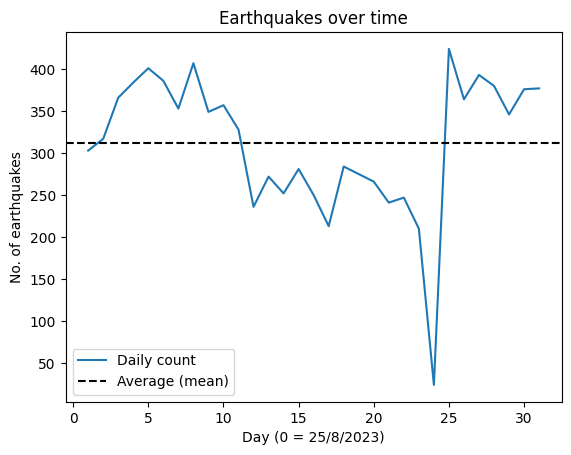

In [3]:
# Re-index dataset w/ new column "day"
df['day'] = pd.DatetimeIndex(df['time']).day

# Group by day. Count earthquakes w/ .size()
daily = df.groupby('day').size()

average = np.mean(daily.values)

# Line plot generation
plt.plot(daily.index, daily.values, label="Daily count")
plt.axhline(y=average, color="black", linestyle="--", label="Average (mean)")
plt.xlabel(f"Day (0 = {min(pd.DatetimeIndex(df['time'])).day}/{min(pd.DatetimeIndex(df['time'])).month}/{min(pd.DatetimeIndex(df['time'])).year})")
plt.ylabel('No. of earthquakes')
plt.title('Earthquakes over time')
plt.legend()
plt.show()

### **Geographical Distribution**
It is determined that the region(s) most affected/ earthquake-prone are on the Western coast of North America, along the Alaska Peninsula down to California.

In [4]:
df["place"].value_counts()

place
7 km NW of The Geysers, CA                   214
Alaska Peninsula                             112
Southern Alaska                              105
7 km SW of Volcano, Hawaii                    96
8 km NW of The Geysers, CA                    88
                                            ... 
57 km NE of Ambler, Alaska                     1
21 km ENE of La Pine, Oregon                   1
54 km ENE of Denali National Park, Alaska      1
48 km SSW of Andalgalá, Argentina              1
19 km S of Central, Alaska                     1
Name: count, Length: 5363, dtype: int64

This can be shown visually with the assistance of a scatter plot. Here the scatter plot has been overlayed onto a map to aid understanding.

<Axes: >

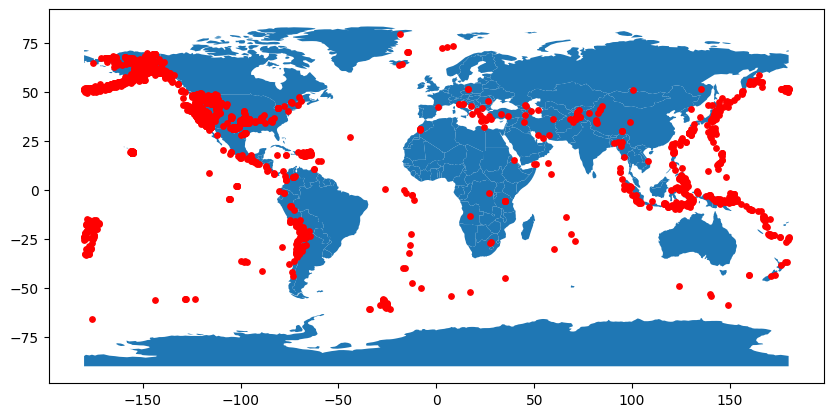

In [5]:
# Scatter plot generation
# List comprehension to generate all points (long+lat) for map
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

# Simple map that goes w/ geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 8)), marker='o', color='red', markersize=15)

### **Magnitude Trends**
This section analyses the distribution of earthquake magnitudes to understand the frequency of small, moderate, and large earthquakes.

First, we decide to only look at ML measured earthquakes for a fairer comparison. This is because not all earthquakes are measured using the same scale.

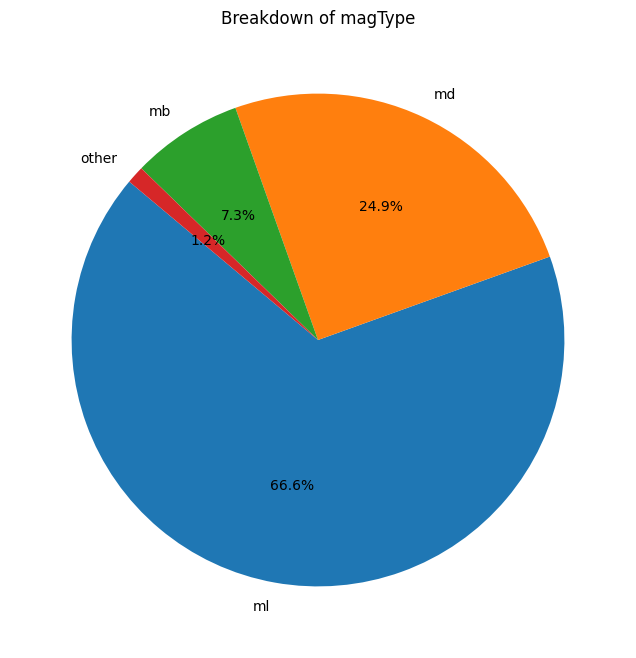

In [6]:
# Group 'magType' values and count their occurrences w/ .value_counts()
renamed = {"mlv": "ml", "ml(texnet)": "ml", "Mb" : "mb", "mb_lg" : "mb", "mw" : "other", "mwr" : "other", "mww" : "other", "mh" : "other"}
grouped_mag_type = df['magType'].replace(renamed).value_counts()

# Pie chart generation
plt.figure(figsize=(8, 8))
plt.pie(grouped_mag_type, labels=grouped_mag_type.index, autopct='%1.1f%%', startangle=140)
plt.title("Breakdown of magType")
plt.show()


As shown in the above Figure, two-thirds (66.6%) of earthquakes in the dataset were measured with an ML scale. The second-most frequently used measurement scale was MD; however, at less than 25% of the data, there is significanly less data to analyse.

Below, the distribution of ML-measured earthquakes has been plotted using a bar chart. Earthquakes have been categorised into groups based on their magnitudes. Unnoticable represents magnitudes below 2, small vibrations are 2-4, medium damage is 4-6, and serious is for magnitudes above 6.

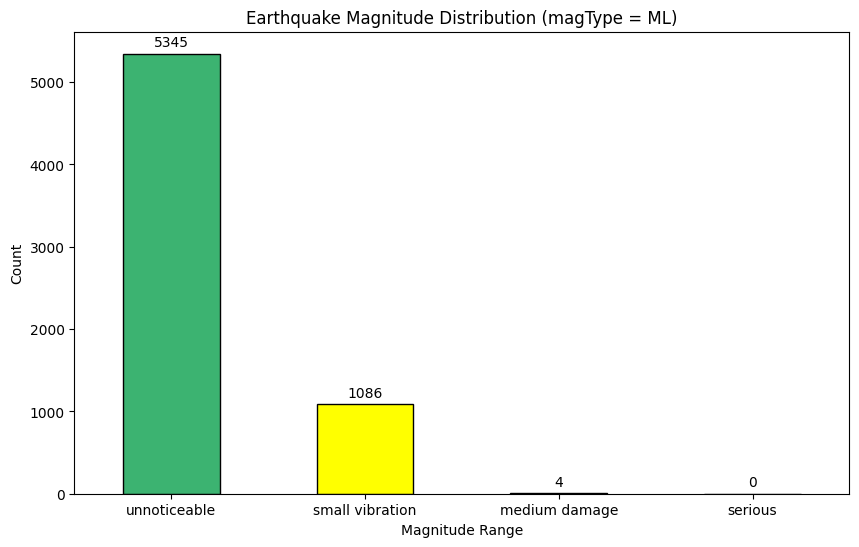

In [24]:
# Define the values you want to filter for
values_to_include = ['ml', 'mlv', 'ml(texnet)']

# Creating a subset w/ only ML values
subset_df = df[df["magType"].isin(values_to_include)]

# Define ranges to later group data into bins
ranges = [-1.5, 2, 4, 6, 7.5]
bar_labels = ["unnoticeable", "small vibration", "medium damage", "serious"]

# Create new column called "range_category"
# cut function to categorise data into bins based on the defined ranges.
subset_df["range_category"] = pd.cut(subset_df['mag'], bins=ranges)

# Group the data by the range categories and count the occurrences in each category.
range_counts = subset_df["range_category"].value_counts()

# Bar chart generation
plt.figure(figsize=(10, 6))
my_colours = ["mediumseagreen","yellow","orange","red"]
bars = range_counts.plot(kind="bar", edgecolor="black", color=my_colours)
plt.xlabel("Magnitude Range")
plt.ylabel("Count")
plt.title("Earthquake Magnitude Distribution (magType = ML)")
plt.xticks(range(len(bar_labels)), bar_labels, rotation=0)

for bar, count in zip(bars.patches, range_counts):
    height = bar.get_height()
    plt.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset for better readability
                 textcoords="offset points",
                 ha="center", va="bottom")
    
plt.show()



It is shown that the majority of earthquakes are unnoticable to humans.

From the ML-measured earthquakes, there was none that caused any serious damage, and 4 that caused medium damage.




### **Depth Analysis**
In this section, we investigate the depths at which different categories of earthquakes occur to gain insights into their correlation.

In the below Figure, you will find a box and whisker plot for the depths at comparison. This Figure uses the complete data set (all magnitude measurement types).

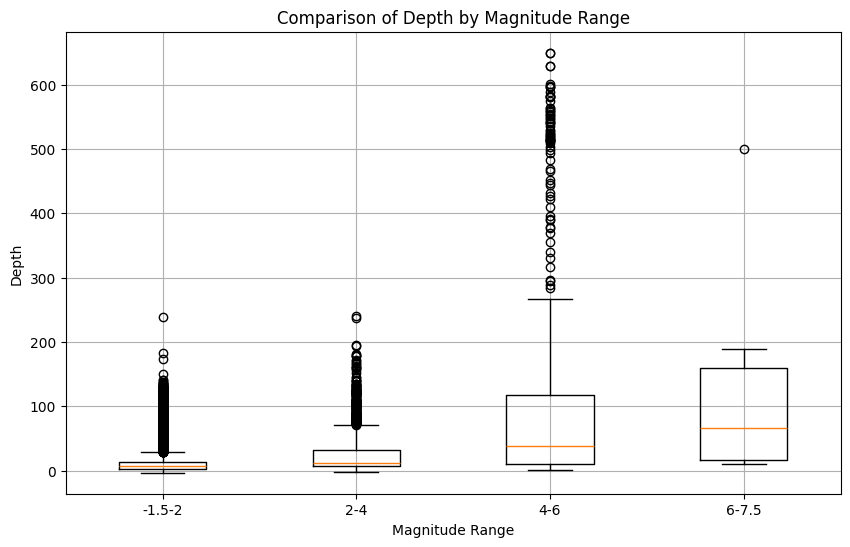

In [ ]:
# To compare depth with magnitude we will use the already established ranges used for magnitude distribution (above)
# For this to work we need to use a list of tuples containing min and max values within each range
range_tuples = [(-1.5,2), (2,4), (4,6), (6,7.5)]

# Initialise an empty list to populate with a FOR loop.
depths_by_mag_range = []

for mag_range in range_tuples:
    min_mag, max_mag = mag_range

    # Filter for earthquakes within the current magnitude range
    filtered = df[(df['mag'] >= min_mag) & (df['mag'] < max_mag)]
    
    # Append depths to the list
    depths_by_mag_range.append(filtered['depth'])

# Boxplot generation
plt.figure(figsize=(10, 6))
plt.boxplot(depths_by_mag_range, labels=[f'{min_mag}-{max_mag}' for min_mag, max_mag in range_tuples])
plt.xlabel('Magnitude Range')
plt.ylabel('Depth')
plt.title('Comparison of Depth by Magnitude Range')
plt.grid(True, which='both')
plt.show()

The box plot (above) shows the correlation between increasing depth and magnitude. Outliers are shown as circles. It should be noted that there exists significantly more datapoints at the lower magnitudes, hence the density of outliers.

## Conclusions



- Average of over 300 earthquakes per day in the timeframe used.
- The most densely affected zone(s) were along the 'ring of fire'
    - Particulary around North America (Alaska Peninsula down to California).
- Majority of earthquakes were harmless/unnoticeable to humans.
- Two-thirds (2/3) of earthquakes were measured using local magnitudes (ML)
- Positive correlation between magnitude and depth.
    - Higher magnitude earthquakes occured at larger depths.